In [132]:
from cp import StructureParser
import datetime
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [133]:
now = str(datetime.datetime.today()).split()[0]
now

'2020-05-06'

In [134]:
working_base_folder = '/media/cryosparc_user/10TB_1/TPP/Lysozyme-06May2020'
os.makedirs("%s/INPUT-%s"% (working_base_folder, now), exist_ok=True)
input_folder = "%s/INPUT-%s"% (working_base_folder, now)
input_folder

'/media/cryosparc_user/10TB_1/TPP/Lysozyme-06May2020/INPUT-2020-05-06'

# READ A LIST OF PDB ID AND DOWNLOAD

In [135]:
to_be_downloaded = pd.read_csv('%s/rcsb_pdb_ids_20200506141543.txt'% working_base_folder, header=None, index_col=False).values.tolist()
valsLower = [item.lower() for item in to_be_downloaded[0]]
len(valsLower)

617

In [136]:
import subprocess
import time
from multiprocessing import Pool


def downl(ids):
    subprocess.call(['wget', 'https://pdb-redo.eu/db/%s/%s_final.pdb'% (ids, ids), '--no-clobber', '--output-document=%s/%s_REDO.pdb'% (input_folder, ids)])
    subprocess.call(['wget', 'https://pdb-redo.eu/db/%s/%s_final.mtz'% (ids, ids), '--no-clobber', '--output-document=%s/%s_REDO.mtz'% (input_folder, ids)])

start_download = time.time()

with Pool(processes=12) as p:
    print(p.map(downl, valsLower[:len(valsLower)]))
    
end_download = time.time()

total_download = (end_download - start_download)
print ('Downloaded and processed %s pdb:mtz pairs in %s seconds'% (len(valsLower),total_download))


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [137]:
mtzs = glob.glob(os.path.join(input_folder, '*.mtz'))
pdbs = glob.glob(os.path.join(input_folder, '*.pdb'))

In [139]:
for filename in mtzs:
    try:
        if os.stat(filename).st_size==0:
            os.remove(filename)
    except FileNotFoundError:
        pass
    
for filename in pdbs:
    try:
        if os.stat(filename).st_size==0:
            os.remove(filename)
    except FileNotFoundError:
        pass

In [140]:
mtz_list = []
mtzs = glob.glob(os.path.join(input_folder, '*.mtz'))
for filename in mtzs:
    mtz_id = os.path.split(filename)[-1][:4]
    mtz_list.append(mtz_id)
mtz_list[:5]

['6kd1', '3p65', '4wly', '1kxx', '2cgi']

In [141]:
def process(ids):
    subprocess.call(['phenix.reciprocal_space_arrays', '%s/%s_REDO.pdb'% (input_folder, ids), '%s/%s_REDO.mtz'% (input_folder, ids), 'output_file_name=%s/%s_phenix.mtz'% (input_folder, ids)])
    ecalc_script='''ecalc hklin {:s} hklout {:s} << eof
        LABI FP=FOBS SIGFP=SIGFOBS
        LABO E=E
        END
eof
        '''.format('%s/%s_phenix.mtz'% (input_folder, ids), '%s/%s_ecalc.mtz'% (input_folder, ids))
    subprocess.call(ecalc_script, shell=True)
    mtz_as_cif_cmd = 'phenix.mtz_as_cif mtz_file={:s} output_file={:s} mtz_labels="FOBS SIGFOBS E SIGE FMODEL PHIFMODEL FOM RESOLUTION" cif_labels="_refln.FOBS _refln.SIGFOBS _refln.E _refln.SIGE _refln.FMODEL _refln.PHI _refln.FOM _refln.RESOL"'.format('%s/%s_ecalc.mtz'% (input_folder, ids), '%s/%s_ecalc.cif'% (input_folder, ids))
    subprocess.call(mtz_as_cif_cmd, shell=True)
    
start_process = time.time()

with Pool(processes=12) as q:
    print(q.map(process, mtz_list[:len(mtz_list)]))

end_process = time.time()

total_process = (end_process - start_process)
print ('Processed %s pdb:mtz pairs in %s seconds'% (len(mtz_list),total_process))

    

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [142]:
cifs = glob.glob(os.path.join(input_folder, '*.cif'))
len(cifs)

584

In [143]:
for pdb in cifs:
    pdb_id = os.path.split(pdb)[-1][:4]
    print(pdb_id)
    try:
        struct = StructureParser('%s/%s_ecalc.cif'%(input_folder, pdb_id), '%s/%s_REDO.pdb'%(input_folder, pdb_id))
        struct.parse()
        struct.structure_df()
        struct.save_to_pkl(os.path.join(input_folder, '%s-%s.pkl'%(pdb_id, now)), pkl_compression=None)
    except Exception:
        pass


3ato
5v4g
4h8y
2ybj
1h87
4etd
4lt0
4tws
3zvq
3wu9
3az6
6hy8
6qww
1uc0
4xjf
1ioq
1kxy
4w96
4owh
4gce
1yl0
4ii8
5o6q
3kam
5kxl
1ykz
5tk0
4nsj
4lt1
3a92
3ok0
1dpw
1jiy
6agn
4ng8
6pbb
5ky1
1lzd
1lz8
3w6a
4kxi
4wm5
4ngj
6g5v
2htx
2ybl
1ior
4lyc
6f1p
1uic
5kxz
4nwe
4ngz
2w1m
3ru5
4b49
4h9e
4eta
3zek
5njr
2xbr
6jxp
5e9r
3ww6
6gnl
3wxu
5iel
4wo6
5apd
4lfx
4ngw
5ilc
6ro3
6ftr
4dda
6f2j
4dd3
6sew
6sij
4ny5
5c6i
3wun
5f14
6agr
5la8
3t6u
4etb
6seu
4lgk
5d5c
3wu8
5f9u
4nhs
6tvl
1lze
4h9c
5njp
5lvj
6qwx
4xyy
6f2i
6jzi
3exd
5ob8
1h6m
2hu1
3p66
4owe
6bo1
6bo2
4n8z
5v4h
4ias
3ems
5k2r
4xad
1zv5
4wo9
3qy4
3a3q
3b72
4lyo
3wum
4ym8
6adf
3n9c
5k2q
1uib
1at5
1yl1
4neb
4h92
5njq
4ddb
4ppo
4h9f
2bpu
5b07
4bad
2g4q
6qxx
3txk
4hv2
4lt2
4ng1
6gob
5kxr
3txf
2d91
6qxy
3a93
5ape
4h1p
4zfp
5lxw
2a7f
6mqv
4ete
4lt3
2ybn
4j1a
4g4h
5kxt
1bvx
6h79
5wrb
1b0d
2xbs
2c8o
5myy
4aga
4n9r
5ob7
5lvg
5lvi
4ngk
1lyo
4nhi
2lym
193l
5hmj
1ir9
4zee
5b5j
4xen
4dd2
4rw2
1kxx
4uwv
1t3p
4a7d
4g4c
6qqf
1yky
5kj9
5ihg
3a8z
1uif
4fjr
1jit


# READ PREVIOUSLY SAVED INDIVIDUAL PICKLE FILES

In [145]:
pkls = glob.glob(os.path.join(input_folder, '*.pkl'))
len(pkls)

584

In [146]:
dfs = []
for pkl in pkls:
    pkl_id = os.path.split(pkl)[-1][:4]
    print (pkl)
    df = pd.read_pickle(pkl, compression=None)
    df['ID'] = pkl_id
    cols_2 = ['FOBS', 'SIGFOBS','E', 'SIGE', 'RESOL']
    df[cols_2] = df[cols_2].round(2)
    # ROUND COLUMN VALUES
    df['PHI'] = df['PHI'].astype(int)
    cols_3 = ['length_a', 'length_b', 'length_c', 'angle_alpha', 'angle_beta', 'angle_gamma']
    df[cols_3] = df[cols_3].astype(int)
    df['HKL'] = df.iloc[:,0].astype(str) + ', ' + df.iloc[:,1].astype(str) + ', ' + df.iloc[:,2].astype(str)
    df["norm_FOBS"] = df["FOBS"] / df["FOBS"].max()
    df["min_max_FOBS"] = (df["FOBS"]-df["FOBS"].min())/(df["FOBS"].max()-df["FOBS"].min())
    df["z_FOBS"] = (df["FOBS"] - df["FOBS"].mean())/df["FOBS"].std()    
#     df['PHI'] = df['PHI'].astype(int)
#     df['PHI'] = df['PHI'].astype(int)
#     df['PHI'] = df['PHI'].astype(int)
#     df['PHI'] = df['PHI'].astype(int)
    df.describe()
    dfs.append(df)

/media/cryosparc_user/10TB_1/TPP/Lysozyme-06May2020/INPUT-2020-05-06/4wld-2020-05-06.pkl
/media/cryosparc_user/10TB_1/TPP/Lysozyme-06May2020/INPUT-2020-05-06/3wua-2020-05-06.pkl
/media/cryosparc_user/10TB_1/TPP/Lysozyme-06May2020/INPUT-2020-05-06/4eta-2020-05-06.pkl
/media/cryosparc_user/10TB_1/TPP/Lysozyme-06May2020/INPUT-2020-05-06/1uib-2020-05-06.pkl
/media/cryosparc_user/10TB_1/TPP/Lysozyme-06May2020/INPUT-2020-05-06/3ok0-2020-05-06.pkl
/media/cryosparc_user/10TB_1/TPP/Lysozyme-06May2020/INPUT-2020-05-06/4qeq-2020-05-06.pkl
/media/cryosparc_user/10TB_1/TPP/Lysozyme-06May2020/INPUT-2020-05-06/4ngk-2020-05-06.pkl
/media/cryosparc_user/10TB_1/TPP/Lysozyme-06May2020/INPUT-2020-05-06/6irj-2020-05-06.pkl
/media/cryosparc_user/10TB_1/TPP/Lysozyme-06May2020/INPUT-2020-05-06/6pbb-2020-05-06.pkl
/media/cryosparc_user/10TB_1/TPP/Lysozyme-06May2020/INPUT-2020-05-06/3rt5-2020-05-06.pkl
/media/cryosparc_user/10TB_1/TPP/Lysozyme-06May2020/INPUT-2020-05-06/6ahl-2020-05-06.pkl
/media/cryosparc_user

In [147]:
dfs[200].FOBS

0         794.90
1        1150.80
2         456.83
3          12.51
4          28.39
          ...   
40313      39.39
40314      29.80
40315      26.15
40316      31.71
40317      26.89
Name: FOBS, Length: 40318, dtype: float64

In [149]:
concat_df = pd.concat(dfs).reset_index(drop=True)
concat_df.columns

Index(['index_h', 'index_k', 'index_l', 'FOBS', 'SIGFOBS', 'FMODEL', 'PHI',
       'FOM', 'RESOL', 'E', 'SIGE', 'pdbx_r_free_flag', 'crystal_system',
       'IT_number', 'name_H-M_alt', 'name_Hall', 'space_group_name_H-M',
       'space_group_name_Hall', 'Int_Tables_number', 'length_a', 'length_b',
       'length_c', 'angle_alpha', 'angle_beta', 'angle_gamma', 'volume',
       'SYNCHROTRON', 'SOLV', 'WILSON', 'MATTHEWS', 'ID', 'HKL', 'norm_FOBS',
       'min_max_FOBS', 'z_FOBS'],
      dtype='object')

In [150]:
concat_df

index_h  index_k  index_l    FOBS  SIGFOBS    FMODEL  PHI       FOM  \
0              1        0        3  522.28     8.16  555.0050  -45  1.000000   
1              1        0        4  302.49     3.45  151.0600   90  1.000000   
2              1        0        5  148.56     1.72   87.6498 -135  0.988002   
3              1        1        3   47.26     1.11  165.6250  -90  0.911433   
4              1        1        4  167.50     2.03  307.9240    0  1.000000   
...          ...      ...      ...     ...      ...       ...  ...       ...   
9728835       64        8        0   55.19     4.12   52.6011    0  1.000000   
9728836       64        8        1   63.93     3.23   70.2054  -76  0.993733   
9728837       64        8        2   47.77     8.18   34.2576  162  0.982712   
9728838       64        9        0   16.53    11.00   24.0219    0  0.998317   
9728839       64        9        1   55.63    10.00   67.9035  121  0.992549   

         RESOL     E  ...      volume  SYNCHROTRON   SOLV  WILSON MATTHEWS  \
0        12.48  1.39  ...  237715.047               40.68    NULL     2.07   
1         9.41  0.81  ...  237715.047               40.68    NULL     2.07   
2         7.55  0.40  ...  237715.047               40.68    NULL     2.07   
3        12.32  0.13  ...  237715.047               40.68    NULL     2.07   
4         9.34  0.45  ...  237715.047               40.68    NULL     2.07   
...        ...   ...  ...         ...          ...    ...     ...      ...   
9728835   1.22  1.04  ...  229819.428               38.64    NULL        2   
9728836   1.22  1.20  ...  229819.428               38.64    NULL        2   
9728837   1.22  0.90  ...  229819.428               38.64    NULL        2   
9728838   1.22  0.31  ...  229819.428               38.64    NULL        2   
9728839   1.22  1.05  ...  229819.428               38.64    NULL        2   

           ID       HKL norm_FOBS  min_max_FOBS    z_FOBS  
0        4wld   1, 0, 3  0.423818      0.422643  3.346205  
1        4wld   1, 0, 4  0.245464      0.243924  1.594336  
2        4wld   1, 0, 5  0.120553      0.118758  0.367414  
3        4wld   1, 1, 3  0.038350      0.036388 -0.440013  
4        4wld   1, 1, 4  0.135922      0.134159  0.518378  
...       ...       ...       ...           ...       ...  
9728835  5dla  64, 8, 0  0.041748      0.039591 -0.557921  
9728836  5dla  64, 8, 1  0.048360      0.046217 -0.488910  
9728837  5dla  64, 8, 2  0.036135      0.033965 -0.616510  
9728838  5dla  64, 9, 0  0.012504      0.010281 -0.863183  
9728839  5dla  64, 9, 1  0.042081      0.039924 -0.554447  

[9728840 rows x 35 columns]

In [151]:
col_hkl_list = concat_df['HKL'].tolist()

In [152]:
col_hkl_list[1]

'1, 0, 4'

In [153]:
for item in col_hkl_list:
     print (concat_df[['index_h', 'index_k', 'index_l', 'E', 'norm_FOBS', 'min_max_FOBS', 'z_FOBS', 'PHI', 'RESOL', 'ID']][concat_df['HKL'] == item ])

         index_h  index_k  index_l     E  norm_FOBS  min_max_FOBS    z_FOBS  \
0              1        0        3  1.39   0.423818      0.422643  3.346205   
17541          1        0        3  1.54   0.465174      0.461694  2.837412   
26112          1        0        3  1.52   0.476827      0.473834  2.743342   
35964          1        0        3  1.25   0.432604      0.426560  2.406292   
47717          1        0        3  1.00   0.301806      0.299958  1.552722   
...          ...      ...      ...   ...        ...           ...       ...   
9654212        1        0        3  1.33   0.320645      0.320390  2.106997   
9669331        1        0        3  1.00   0.282627      0.278922  0.811818   
9674679        1        0        3  1.41   0.423084      0.420357  2.707766   
9683266        1        0        3  1.14   0.329844      0.326958  1.973216   
9694843        1        0        3  1.47   0.396696      0.395337  3.147149   

         PHI  RESOL    ID  
0        -45  12.48  4w

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16, 20))

sns.distplot(concat_df['RESOL'], kde=False)

In [154]:
concat_df.drop(columns=['WILSON', 'SOLV', 'SYNCHROTRON', 'pdbx_r_free_flag', 
                        'IT_number', 'pdbx_r_free_flag', 'IT_number',
                        'name_Hall', 'space_group_name_H-M', 'space_group_name_Hall', 
                        'Int_Tables_number'], inplace=True)
## CHECK IF INPUTERS ARE NEEDED, in case of NaN
concat_df.isnull().values.any()
concat_df.isnull().sum()

index_h           0
index_k           0
index_l           0
FOBS              0
SIGFOBS           0
FMODEL            0
PHI               0
FOM               0
RESOL             0
E                 0
SIGE              0
crystal_system    0
name_H-M_alt      0
length_a          0
length_b          0
length_c          0
angle_alpha       0
angle_beta        0
angle_gamma       0
volume            0
MATTHEWS          0
ID                0
HKL               0
norm_FOBS         0
min_max_FOBS      0
z_FOBS            0
dtype: int64

In [155]:
unique = concat_df['ID'].nunique()
unique

584

In [156]:
concat_df['ID'].value_counts()

1iee    72343
4b4e    62259
5lxw    57555
6ro3    55331
3ajn    53946
        ...  
4hv2     3359
6w8e     3121
3txk     2473
4ddb     1843
4gcf     1728
Name: ID, Length: 584, dtype: int64

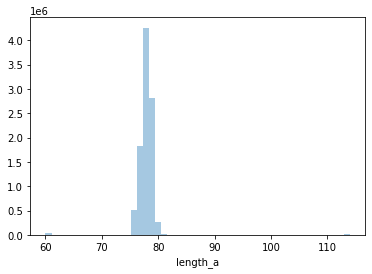

In [157]:
sns.distplot(concat_df['length_a'], kde=False)


In [158]:
concat_df.to_pickle('%s/%s-lysozyme-%s.pkl.gz'%(input_folder, unique, now), compression='gzip')

In [159]:
reloaded_df = pd.read_pickle('%s/%s-lysozyme-%s.pkl.gz'%(input_folder, unique, now), compression='gzip')

In [161]:
Q1 = reloaded_df['length_a'].quantile(0.01)
Q3 = reloaded_df['length_a'].quantile(0.99)
Q1, Q3

(76.0, 80.0)

In [162]:
indexNames = reloaded_df[ (reloaded_df['length_a'] < Q1)].index
indexNames
reloaded_df.drop(indexNames , inplace=True)
indexNames = reloaded_df[ (reloaded_df['length_a'] > Q3)].index
indexNames
reloaded_df.drop(indexNames , inplace=True)


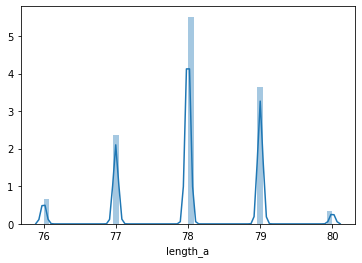

In [163]:
sns.distplot(reloaded_df['length_a'])


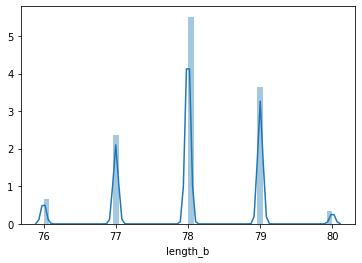

In [164]:
sns.distplot(reloaded_df['length_b'])

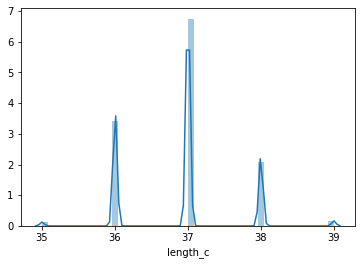

In [165]:
sns.distplot(reloaded_df['length_c'])

In [166]:
reloaded_df.columns

Index(['index_h', 'index_k', 'index_l', 'FOBS', 'SIGFOBS', 'FMODEL', 'PHI',
       'FOM', 'RESOL', 'E', 'SIGE', 'crystal_system', 'name_H-M_alt',
       'length_a', 'length_b', 'length_c', 'angle_alpha', 'angle_beta',
       'angle_gamma', 'volume', 'MATTHEWS', 'ID', 'HKL', 'norm_FOBS',
       'min_max_FOBS', 'z_FOBS'],
      dtype='object')

In [ ]:
reloaded_df.to_pickle('%s/%s-lysozyme-primed-%s.pkl.gz'%(input_folder, unique, now), compression='gzip')

In [ ]:
primed_df = pd.read_pickle('%s/%s-lysozyme-primed-%s.pkl.gz'%(input_folder, unique, now), compression='gzip')

In [ ]:
def get_reciprocal(primed_df, columns=['index_h', 'index_k', 'index_l']):
    for col in columns:
        col_name  = "rec_%s"%col
        primed_df[col_name] = 1.0/primed_df[col]

In [ ]:
import numpy as np
get_reciprocal(primed_df)
primed_df.replace([np.inf, -np.inf], 0.0 ,inplace=True)
primed_df[primed_df == np.inf].sum().sum()

In [ ]:
primed_df['cos_phi'] = np.cos(primed_df['PHI'])
primed_df['cos_phi']

In [ ]:
primed_df['sin_phi'] = np.sin(primed_df['PHI'])
primed_df['sin_phi']